<a href="https://colab.research.google.com/github/evacragnolino/Data-Science-Foundations/blob/main/Eva_C_Unit6ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import graphviz as gv
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install bambi

In [ ]:
import bambi as bmb

# Unit 6 Exercises: Is my model good?

#### Over and Under fitting, Model Visualization, and Model/Variable Selection Concepts

These exercises are meant to get you to think about the model and variable selection process, and consider how we determine if a model is "good".

**Task1**:

Does elpd_loo mean anything if we only have one model?

No, beacause elpd_loo compares the performance of models so it needs multiple models.

**Task2**:

Describe overfitting, in the context of this course

Overfitting is when the model predicts the data given to it well but cannot predict other similar situations. This is because the model overfits the spcific data and not the general variation of similar data.

**Task3**:

How do we mitigate overfitting?

having a lot of weak priors and variables.

**Task4**:

How do we mitigate underfitting?

use more complex models with more nuance and variables.

**Task5**:

Why would we want more than one predictor in a model?

to prevent overfitting and underfitting.

**Task6**:

Can we have too many predictors? How would we know?

yes, the model would be overfitted.

**Task7**:

What is variable selection, and how does it work?

you want to select a lot of variables so the model predicts well but these need be fluid and help the model with other data as well.

**Task8**:

Describe the differences and similarities between the following three models: linear regression with two predictors, one of which is a categorical variable:

- adding the variables in the model, as is standard.
- using that categorical variable as a hierarchy upon the other predictor variable.
- adding the variables, plus the categorical variable's interaction with the other variable.

adding the variables, plus the categorical variable's interaction with the other variable is best for the model because it adds nuance and prevents overfitting. adding the variables in the model, as is standard is wourse because because it might overfit the model if the variebles act as proxies for each other. Using that categorical variable as a hierarchy upon the other predictor variable is in the middle but it lacks nuance since many times the variables affect each other.

**Task9**:

How do we visualize multiple linear regression models? Can we visualize the entire model, all at once?

you can see the whole model up to a point but after that it needs to be split up into multiple plots to sample an idea of the whole model by looking at slices.

**Task10**:

Compare the following linear models that all use the basketball data to predict field goal percentage:

- predictors free throw percentage and position (with position as a categorical predictor)
- predictors free throw percentage and position (with position as a hierarchy)
- predictors free throw percentage and position (with position interacting with frew throw percentage)
- predictors free throw percentage, position, 3 point attempts, and interactions between all three predictors
- predictors free throw percentage, position, 3 point attempts, with an interaction between 3 point attempts and postion.

using ```az.compare()``` and ```az.plot_compare()```, or an equivalent method using LOO (elpd_loo).

You may use the following two code blocks to load and clean the data.

In [ ]:
#have to drop incomplete rows, so that bambi will run
bb = pd.read_csv(
    'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv'
    ).dropna()

In [ ]:
#only look at players who played more than 600 minutes
#which is 20 min per game, for 30 games
bb = bb.query('MP > 600')
#remove players who never missed a free throw
bb = bb.query('`FT%` != 1.0')
#filter out the combo positions. This will make it easier to read the graphs
bb = bb.query("Pos in ['C','PF','SF','SG','PG']")
#gets rid of the annoying '%' sign
bb.rename(columns={"FT%":"FTp","FG%":"FGp"}, inplace=True)

In [ ]:
#categorical
#define the model
model_bb = bmb.Model("FGp ~ FTp + Pos", data=bb)
#fit the model
idata_bb = model_bb.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
# hierchal
#define the model, but as a hierarchy
model_bb_h = bmb.Model("`FGp` ~ (`FTp`|Pos)", data=bb)
#create the model
idata_bb_h = model_bb_h.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
# interacting or 3
#define the model; bb_inter stands for baskeball interaction
model_bb_inter_3 = bmb.Model("`FGp` ~ `FTp` + Pos + `FTp`:Pos", data=bb)
#create the model
idata_bb_inter_3 = model_bb_inter_3.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
# interacting4 or 4
#define the model as: predictors free throw percentage, position, 3 point attempts, and interactions between all three predictors
model_bb_inter_4 = bmb.Model("`FGp` ~ `FTp` + Pos + `3PA` + `FTp`:Pos + `FTp`:`3PA` + Pos:`3PA` + `FTp`:Pos:`3PA`", data=bb)
#create the model
idata_bb_inter_4 = model_bb_inter_4.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
# interacting or 5
#define the model; bb_inter stands for baskeball interaction
model_bb_inter_5 = bmb.Model("`3PA` ~ `FTp` + Pos + `3PA`:Pos", data=bb)
#create the model
idata_bb_inter_5 = model_bb_inter_5.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
cmp_df = az.compare( {"1":idata_bb,"2":idata_bb_h,"3":idata_bb_inter_3,"4":idata_bb_inter_4,"5":idata_bb_inter_5} )

#0 is the best rank; we want a lower elpd_loo
cmp_df

/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
5,0,5495.411735,1.350349,0.000000,1.0,0.236919,0.000000,False,log
4,1,529.956488,21.945890,4965.455247,0.0,14.417905,14.401728,True,log
3,2,509.261713,13.927510,4986.150022,0.0,16.787119,16.760968,True,log
2,3,508.203594,13.875237,4987.208140,0.0,17.070836,17.043084,False,log
1,4,507.178270,8.481176,4988.233465,0.0,16.088292,16.059920,False,log


**Task11**:

Which model is "better" according to this metric?

Why do you think that is?

5 is the best because it has the most positive elpd_loo

**Task12:**

The body data set has a measure of body fat percentage (siri), as well as several other measurments of other parts of a person's body, plus their age.

Create a sensible causal diagram for this set of variables.

Based on your causal diagram, which variable should you try to predict? Why?

In [ ]:
body = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/body_fat.csv')

In [ ]:
body.head()

,siri,age,weight,height,abdomen,thigh,wrist
0,12.3,23,70.1,172,85.2,59.0,17.1
1,6.1,22,78.8,184,83.0,58.7,18.2
2,25.3,22,70.0,168,87.9,59.6,16.6
3,10.4,26,84.0,184,86.4,60.1,18.2
4,28.7,24,83.8,181,100.0,63.2,17.7


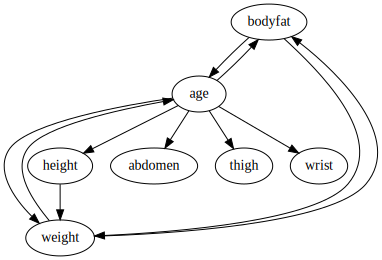

In [ ]:
s_dag = gv.Digraph(name="Body DAG")

s_dag.node('B','bodyfat')
s_dag.node('A','age')
s_dag.node('W','weight')
s_dag.node('H','height')
s_dag.node('S','abdomen')
s_dag.node('T','thigh')
s_dag.node('R','wrist')
s_dag.edges([('A','T'),('A','W'),('A','S'),('A','R'),('A','B'),('A','H'),('H','W'),('B','W'),('W','B'),('B','A'), ('W','A')])

s_dag

I think I should predict either bodyfat or abdomen beacuse they seem to be affected by the other variables.